In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [2]:
from visuals import save_graph_in_folder

In [3]:
df = pd.read_json(os.path.join('input', 'train.json'))
shape = (75,75)

In [4]:
for band in ['band_1', 'band_2']:
    df[band] = df[band].apply(np.asarray)
df.loc[df['inc_angle'] == 'na', 'inc_angle'] = np.nan

In [5]:
df['angle_NaN'] = df.inc_angle.isnull()

In [6]:
df['category'] = df.is_iceberg.apply(lambda row: 'ships' if row == 0 else 'icebergs')

### Data Exploration Images

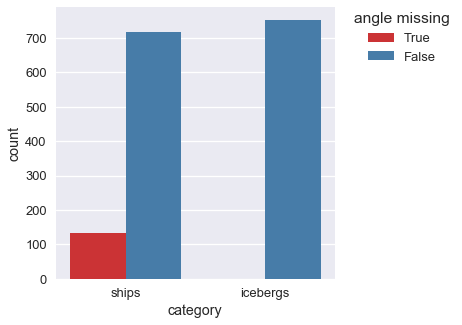

In [7]:
sns.set(context='talk', style='darkgrid')
plt.figure(figsize=(5,5))
sns.countplot(x='category', hue='angle_NaN', data=df, palette='Set1', hue_order=[True, False]);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='angle missing');
save_graph_in_folder('capstone_report', 'angle_na_count.png')

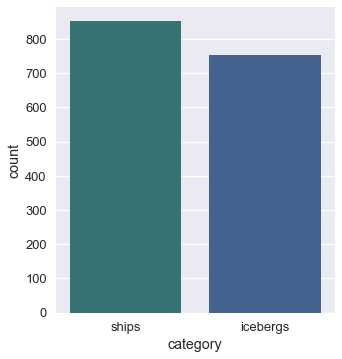

In [8]:
plt.figure(figsize=(5,5*(9/8)))
sns.countplot(x='category', data=df, palette='winter_r', saturation=.35);
save_graph_in_folder('capstone_report', 'train_data_dist.png')

###  Pick example iceberg to graph 

###### Grab Band_1 dB Levels

In [9]:
ice_example = df[df.is_iceberg == 1].sample(1)
ice_id = ice_example.iloc[0].id
iceberg = ice_example.iloc[0].band_1

### Normalization and Scaling of dB

In [10]:
iceberg = scale(iceberg)

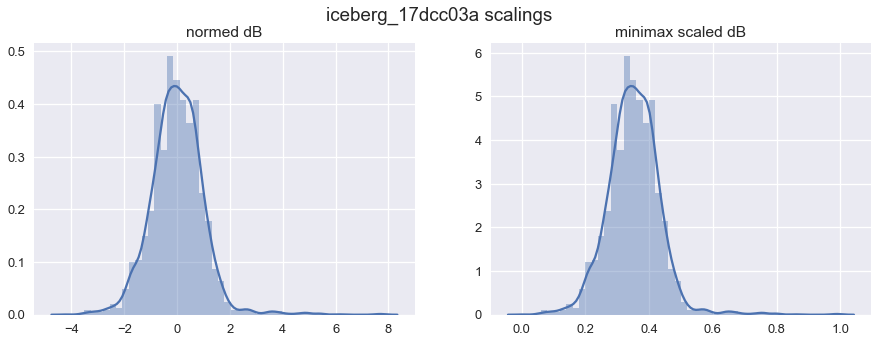

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('normed dB')
sns.distplot(iceberg);

def mima(arr):
    return (arr - arr.min()) / abs(arr.max() - arr.min())

plt.subplot(122)
minimax = mima(iceberg)
plt.title('minimax scaled dB')
sns.distplot(minimax);
plt.suptitle('iceberg_{id} scalings'.format(id=ice_id));

###### Heatmap of dB

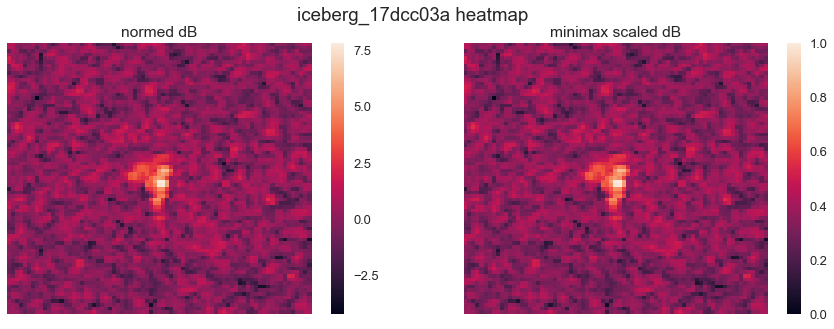

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(121)
iceberg2d = iceberg.reshape(75,75)
sns.heatmap(iceberg2d, xticklabels=False, yticklabels=False);
plt.title('normed dB')
plt.subplot(122)
minmax2d = minimax.reshape(75,75)
sns.heatmap(minmax2d, xticklabels=False, yticklabels=False);
plt.title('minimax scaled dB')
plt.suptitle('iceberg_{} heatmap'.format(ice_id));

### Bentes Normalization

In [13]:
from functools import reduce

def L(x):
    return 1 + np.log(x) if x > 1 else x

def bentes_norm(arr):
    Larr = np.fromiter((L(x) for x in arr), dtype=arr.dtype, count=reduce(lambda a,b: a*b, arr.shape))
    maxL = abs(Larr.max())
    return Larr / maxL

In [14]:
tbentes = 'bentes normalized dB'
tnorm = 'normalized dB'

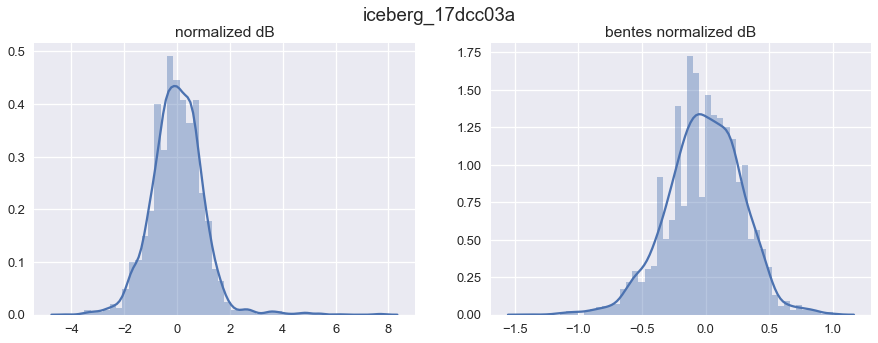

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(iceberg)
plt.title(tnorm)
plt.subplot(122)
bentes = bentes_norm(iceberg)
plt.title(tbentes)
sns.distplot(bentes);
plt.suptitle('iceberg_{}'.format(ice_id));

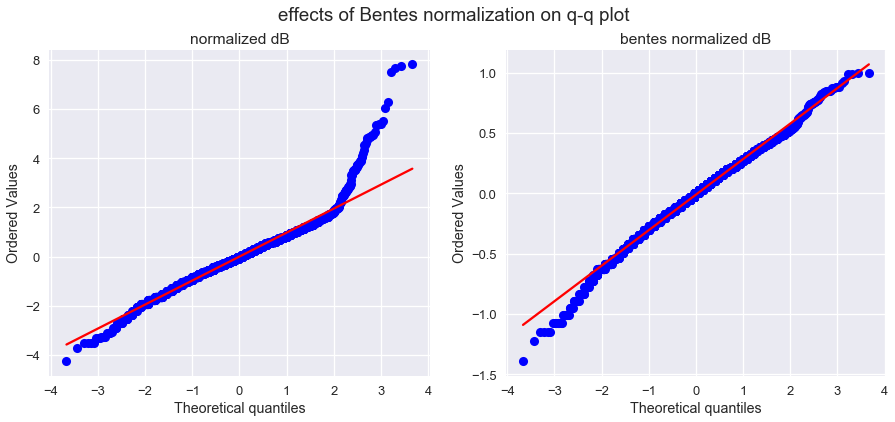

In [16]:
from scipy import stats

plt.figure(figsize=(15,6))
plt.subplot(121)
stats.probplot(iceberg, plot=plt)
plt.title(tnorm)
plt.subplot(122)
stats.probplot(bentes, plot=plt)
plt.title(tbentes)
plt.suptitle('effects of Bentes normalization on q-q plot')
plt.show()

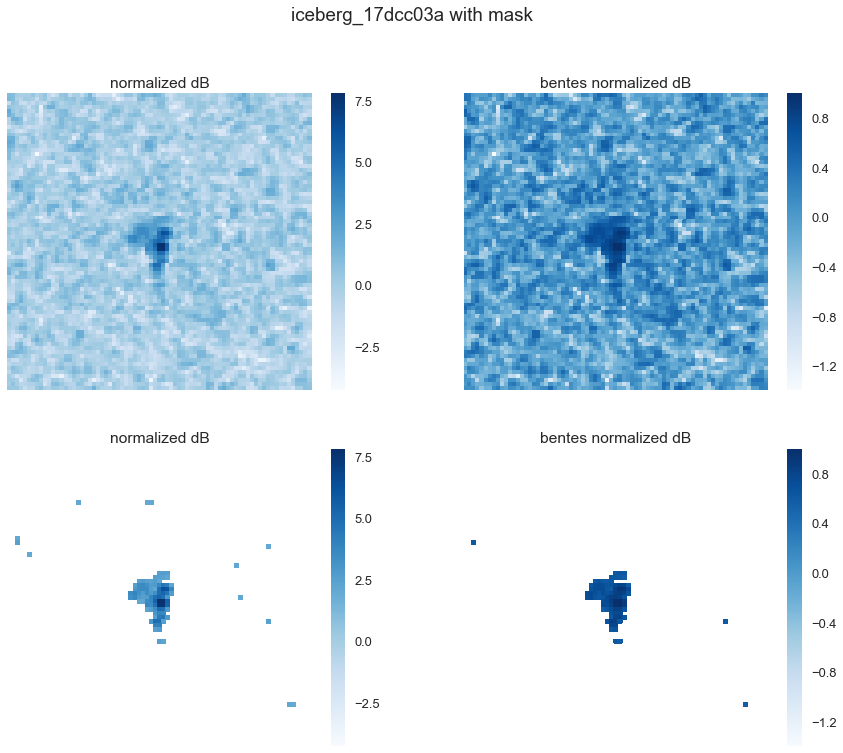

In [17]:
bentes2d = bentes.reshape(75,75)
ice2d = iceberg.reshape(75,75)

mask = lambda arr: arr < arr.mean() + 2*arr.std()
cmap = 'Blues'
with sns.axes_style('white'):
    plt.figure(figsize=(15,12))
    plt.subplot(221)
    sns.heatmap(ice2d, xticklabels=False, yticklabels=False, cmap=cmap)
    plt.title(tnorm)
    plt.subplot(223)
    sns.heatmap(ice2d, xticklabels=False, yticklabels=False, mask=mask(ice2d), cmap=cmap)
    plt.title(tnorm)
    plt.subplot(222)
    sns.heatmap(bentes2d, xticklabels=False, yticklabels=False, cmap=cmap)
    plt.title(tbentes)
    plt.subplot(224)
    sns.heatmap(bentes2d, xticklabels=False, yticklabels=False, mask=mask(bentes2d), cmap=cmap)
    plt.title(tbentes)
    plt.suptitle('iceberg_{} with mask'.format(ice_id))
    plt.show()

###### 3D Plotly Graphs of Iceberg

In [18]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)


def plot_3d_example(band_data, name):
    surface = go.Surface(
        z=band_data,
        colorbar={'title': 'dB'}
    )
    data = [surface]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [19]:
ice_mean = 0.0 if np.isclose(iceberg.mean(), 0.) else iceberg.mean()
ice_std = 0.0 if np.isclose(iceberg.std(), 1.) else iceberg.std()
print('mean', ice_mean, 'std', iceberg.std())
plot_3d_example(ice2d, 'iceberg_{} | '.format(ice_id)+tnorm)

mean 0.0 std 1.0


In [20]:
print('mean', round(bentes.mean(), 4), 'std', round(bentes.std(), 4))
plot_3d_example(bentes2d, 'iceberg_{} | '.format(ice_id)+tbentes);

mean -0.0098 std 0.2952


### Incidence Angle

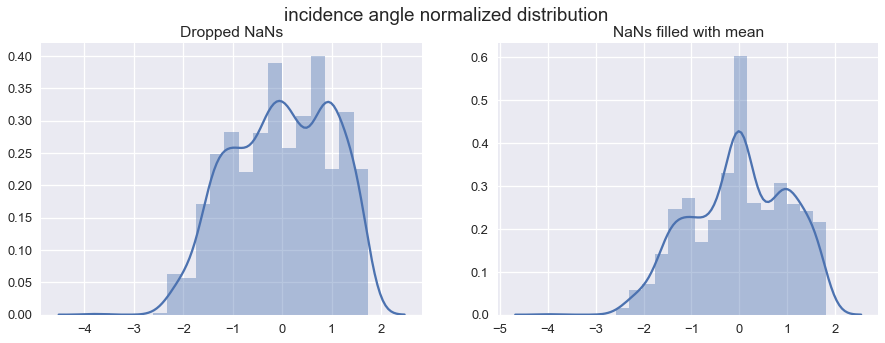

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(121)
dropped_angle = df.inc_angle.dropna().astype(float)
sns.distplot(scale(dropped_angle));
plt.title('Dropped NaNs')
plt.subplot(122)
filled_angle = df.inc_angle.fillna(df[df.is_iceberg == 0].inc_angle.mean())
sns.distplot(scale(filled_angle));
plt.title('NaNs filled with mean')
plt.suptitle('incidence angle normalized distribution')
plt.show()

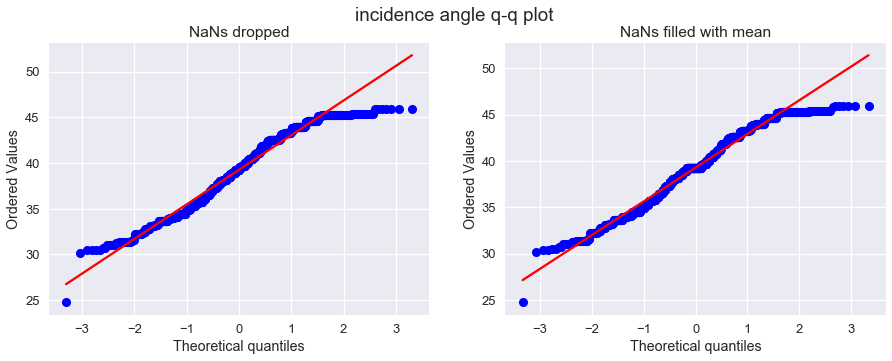

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(121)
stats.probplot(dropped_angle, plot=plt)
plt.title('NaNs dropped')
plt.subplot(122)
stats.probplot(filled_angle, plot=plt)
plt.title('NaNs filled with mean')
plt.suptitle('incidence angle q-q plot')
plt.show()

In [23]:
min_inc_angle_idx = df[df.inc_angle == df.inc_angle.min()].index[0]

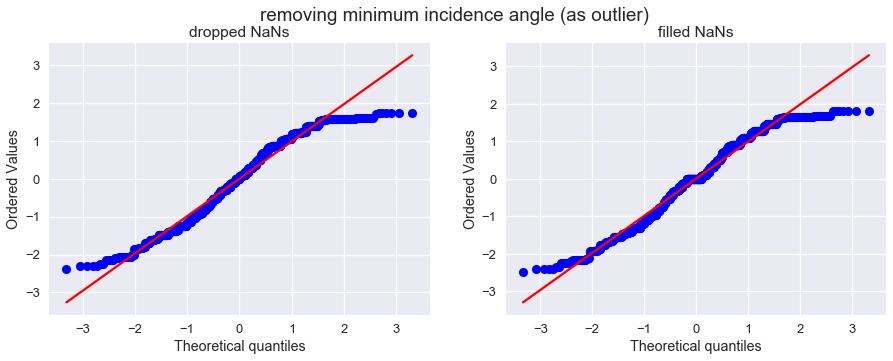

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(121)
stats.probplot(scale(dropped_angle.drop(min_inc_angle_idx)), plot=plt)
plt.title('dropped NaNs')
plt.subplot(122)
stats.probplot(scale(filled_angle.drop(min_inc_angle_idx)), plot=plt)
plt.title('filled NaNs')
plt.suptitle('removing minimum incidence angle (as outlier)')
plt.show()